<a href="https://colab.research.google.com/github/AmrMKayid/FaceGAN/blob/demo/FaceGAN_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title #**Cloning FaceGAN** { display-mode: "form" }
%%bash
rm -rf /content/* /content/.git* 2> /dev/null 
git clone -b demo https://github.com/AmrMKayid/facegan.git /tmp/facegan
mv /tmp/facegan/* /tmp/facegan/.git* . 
rm -rf /tmp/facegan

Cloning into '/tmp/facegan'...


In [2]:
#@title #**Install the required components** { display-mode: "form" }
%%time
%tensorflow_version 1.x
!pip install tensorflow-gpu==1.14

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import math
import pickle
import imageio
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
import moviepy.editor as mpy
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

clear_output()
import tensorflow as tf
import dnnlib
import pretrained_networks
import dnnlib.tflib as tflib

vgg16 = 'vgg16_zhang_perceptual.pkl'
model = 'stylegan2-ffhq-config-f.pkl'
print(tf.__version__)

1.15.2
CPU times: user 2.06 s, sys: 553 ms, total: 2.61 s
Wall time: 1min 22s


In [3]:
#@title #**Imports & necessary functions** { display-mode: "form" }
from facegan import ROOT_PATH
import facegan.utils.utils as utils

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
def move_latent_and_save(latent_vector, direction_file, coeffs, Gs_network, Gs_syn_kwargs):
    direction = np.load(f'{ROOT_PATH}/data/latent_directions/{direction_file}')
    os.makedirs(f'{ROOT_PATH}/data/results/{direction_file.split(".")[0]}', exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
        result = PIL.Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, PIL.Image.ANTIALIAS)
        result.save(f'{ROOT_PATH}/data/results/' + direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        if len(coeffs)==1:
          return result

Photo Saved

Image photo.jpg is saved! with shape (1024, 1024, 3)


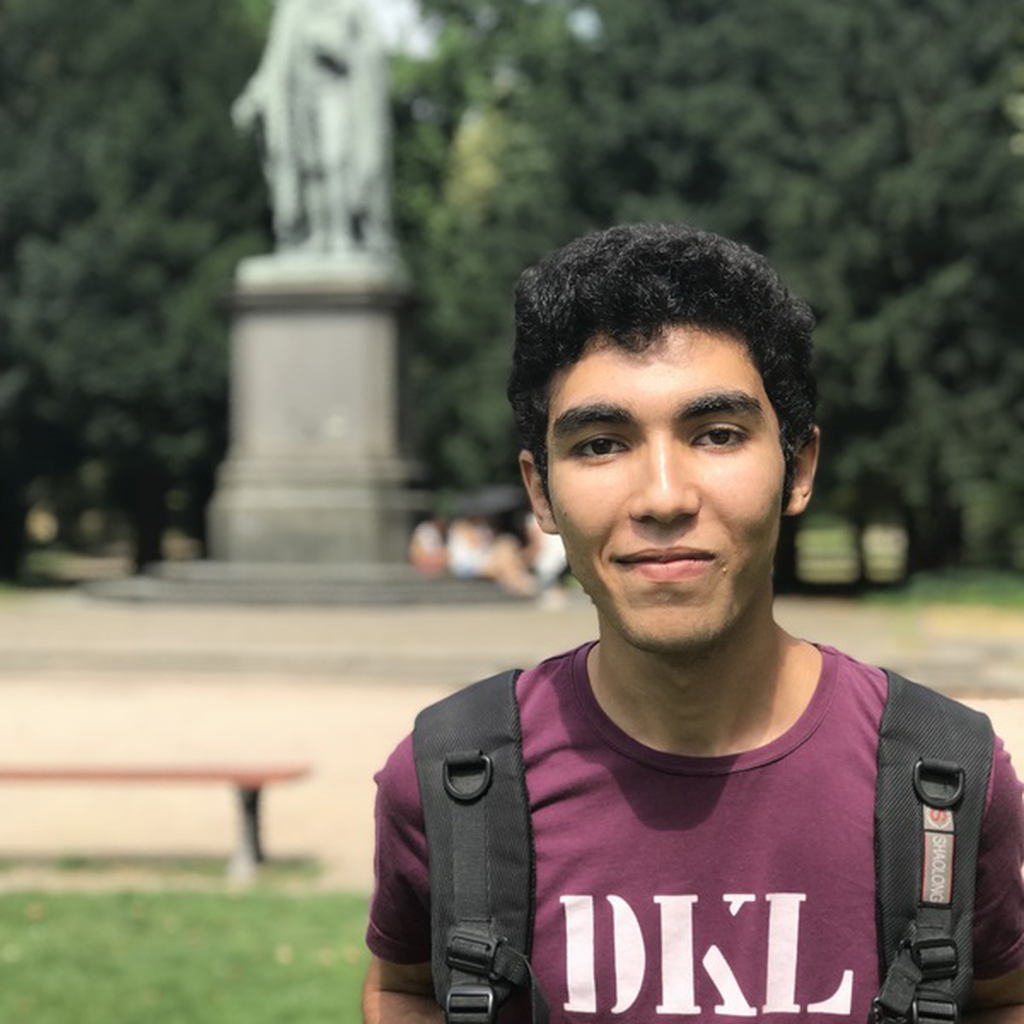

In [4]:
#@title #**Add/Upload a photo with a face** { display-mode: "form" }

#@markdown ### You can choose between taking a photo through **WebCam**, **Upload** a photo from your device, or past a **URL** to get a photo.
!rm -rf $ROOT_PATH/data/raw/*
method = 'url' #@param ["webcam", "url", "upload"]

if method == 'webcam':
  image, fn = utils.take_photo()
elif method == 'url':
  try:
    #@markdown ---
    url = 'https://d3000t1r8yrm6n.cloudfront.net/images/participants/image_file/3369/Amr3.jpg' #@param {type:"string"}
    !wget $url
    fp = url.split('/')[-1]
  except BaseException:
    print("Something went wrong. Try uploading photos from your computer")
else:
  image = files.upload()
  for fp in image.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fp, length=len(image[fp])))
    
if method != 'webcam':
  os.rename(fp, fp.replace(" ", ""))
  fp = fp.replace(" ", "")
  fn = 'photo.'+ fp.split('.')[-1]
  !mv $fp /content/facegan/data/raw/$fn
  clear_output()
  print("Photo Saved\n")

  image = PIL.Image.open('/content/facegan/data/raw/' + fn)
  wpercent = (1024 / float(image.size[0]))
  hsize = int((float(image.size[1])*float(wpercent)))
  image = image.resize((1024, hsize), PIL.Image.LANCZOS)

print(f"Image {fn} is saved! with shape {np.array(image).shape}")
display(image)

In [5]:
#@markdown ---
#@markdown ---
#@markdown ---

In [6]:
#@title #**Multiface Detection** { display-mode: "form" }

!rm -rf $ROOT_PATH/data/cropped/*
#@markdown ### Running this cell if there is more than one face in the image

multiface = False #@param {type:"boolean"}

if multiface:
  from facegan.process.multifaces import MultiFaceCropper

  mfc = MultiFaceCropper()
  image = mfc.crop(np.array(image))
  print(image)
  display(Image.fromarray(image[0]).resize((256,256), PIL.Image.LANCZOS))

In [7]:
#@markdown ---
#@markdown ---
#@markdown ---

Aligning photo.png ...
Starting face alignment...
<PIL.Image.Image image mode=RGB size=600x600 at 0x7F02D025E208>
Wrote result /content/facegan/data/aligned/photo.png


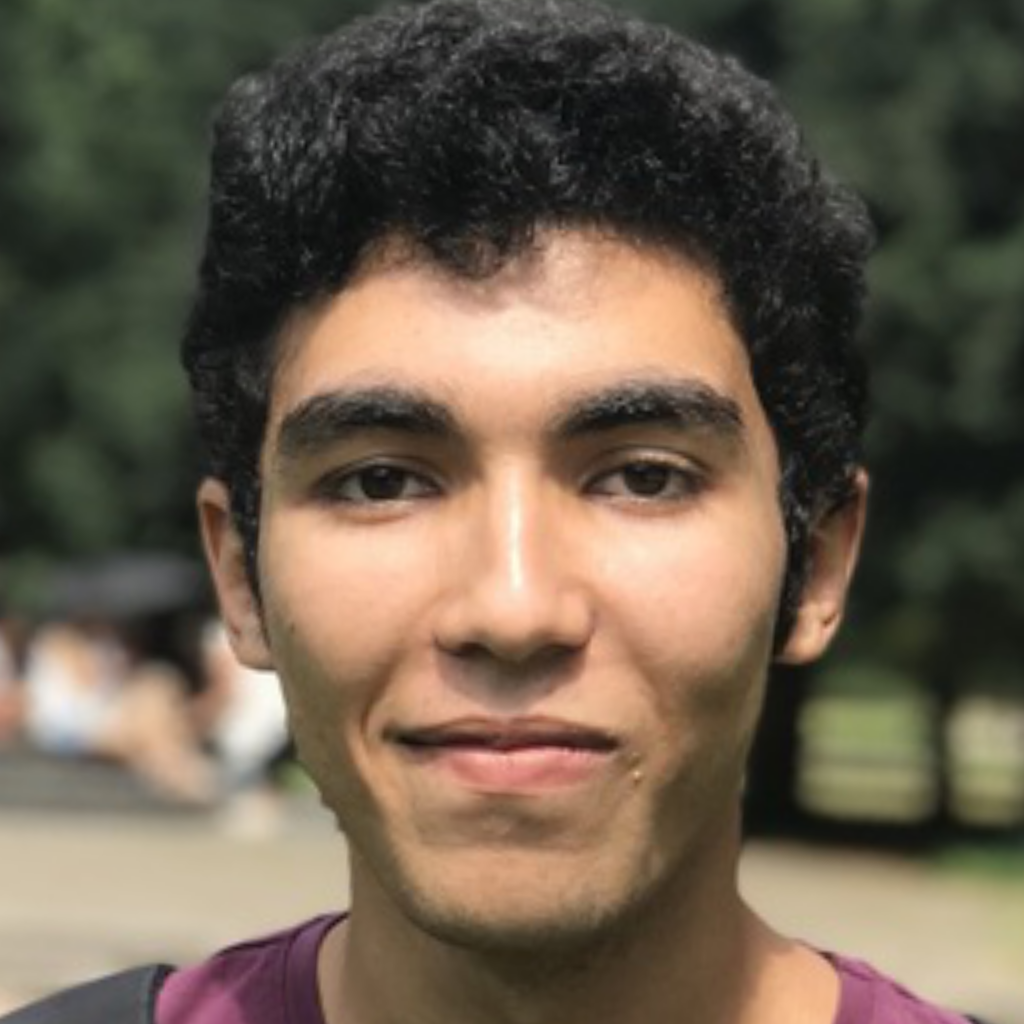

In [8]:
#@title #**Face Alignment** { display-mode: "form" }

#@markdown ### Aligning the face to match the model dataset
from facegan.process.align_images import FaceAligner

!rm -rf $ROOT_PATH/data/aligned/*

face_aligner = FaceAligner()
if multiface:
  images = face_aligner.auto_align()
else:
  images = face_aligner.auto_align(raw_dir=f'{ROOT_PATH}/data/raw')

for image in images:
  image = image.resize((1024,1024), PIL.Image.LANCZOS)
  display(image)

In [9]:
#@markdown ---
#@markdown ---
#@markdown ---

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

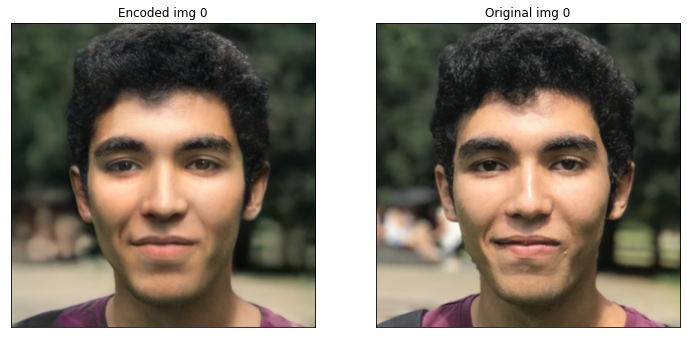


CPU times: user 2.72 s, sys: 498 ms, total: 3.22 s
Wall time: 12min 10s


In [12]:
#@title #**StyleGAN Encoding** { display-mode: "form" }
%%time
!rm -rf $ROOT_PATH/data/latent_representations/* $ROOT_PATH/data/generated/*
#@markdown ### Encoding the aligned images into the latent space of StyleGANs
#@markdown <br> 

#@markdown ---
#@markdown ---
#@markdown **Choose an image encoding method:**

#@markdown *Slow method works 2 times longer, but has much higher quality.*
method = 'Slow (high quality)' #@param ["Fast (low quality)", "Slow (high quality)"]
#@markdown ---

#@markdown **Select a network that matches the type of face in the input image.:**
network = 'european' #@param ["default", "european", "asian", "asian beauty", "baby"]
#@markdown ---
from facegan.utils import nets
# network_path = nets.download_networks(network)

#@markdown **Set the number of iterations of network learning:**

#@markdown *Recommended: 700*
iterations = 700 #@param {type:"slider", min:100, max:1500, step:50}
#@markdown ---

#@markdown **Set learning rate:**

#@markdown *Recommended: 0.1*
learning_rate = 0.1 #@param {type:"slider", min:0.001, max:1, step:0.001}
#@markdown ---

#@markdown **Delete logs after executing this block:**
delete_logs = False #@param {type:"boolean"}
#@markdown ---

if method == 'Slow (high quality)':
  !python project_images.py \
    $ROOT_PATH/data/aligned/ \
    $ROOT_PATH/data/generated/ \
    --vgg16-pkl $ROOT_PATH/data/models/vgg16_zhang_perceptual.pkl \
    --num-steps $iterations \
    --initial-learning-rate $learning_rate \
    --network-pkl $network_path \
    --video=False
  align = !ls $ROOT_PATH/data/aligned/
  for i in align:
    vector_name = i.split('.')[0]+'.npy'
    !mv $ROOT_PATH/data/generated/$vector_name $ROOT_PATH/data/latent_representations/$vector_name
else:
  !python encode_images.py \
    $ROOT_PATH/data/aligned/ \
    $ROOT_PATH/data/generated/ \
    $ROOT_PATH/data/latent_representations/ \
    --network_pkl $network_path \
    --image_size 1024 \
    --iterations $iterations \
    --lr $learning_rate \
    --batch_size 2

fn = !ls $ROOT_PATH/data/latent_representations/
pass
if delete_logs:
  clear_output()
display_sbs(f'{ROOT_PATH}/data/generated/', 
            f'{ROOT_PATH}/data/aligned/', 
            res = 512)

In [ ]:
#@markdown ---
#@markdown ---
#@markdown ---

In [14]:
#@title #**Configure the generator for avg latent** { display-mode: "form" }

tflib.init_tf()
with open(network_path, "rb") as f:
  generator_network, discriminator_network, Gs_network = pickle.load(f)

w_avg = Gs_network.get_var('dlatent_avg')
noise_vars = [var for name, var in Gs_network.components.synthesis.vars.items() if name.startswith('noise')]
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 1
truncation_psi = 0.5
clear_output()

In [15]:
#@markdown ---
#@markdown ---
#@markdown ---

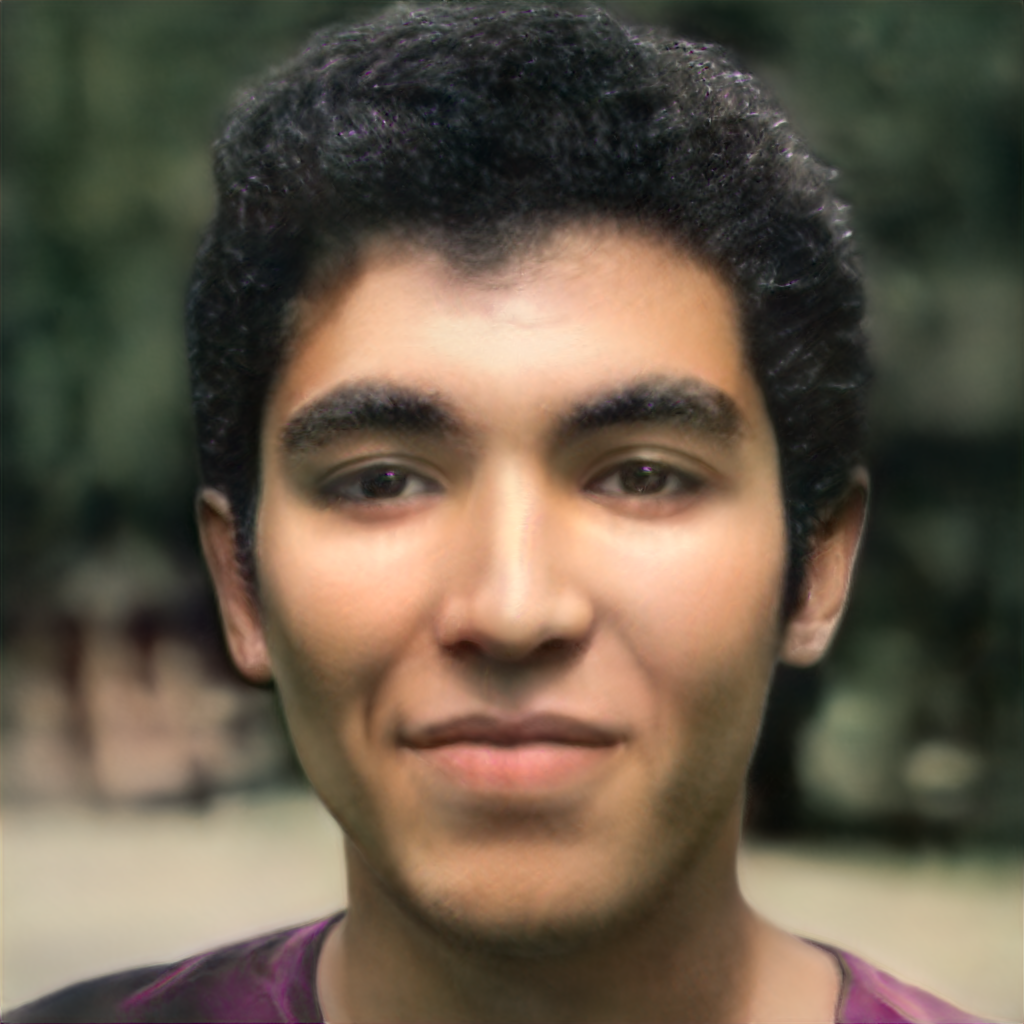

In [18]:
#@title #**Modify the face in photo** { run: "auto", display-mode: "form" }
from google.colab import files

fn = !ls $ROOT_PATH/data/latent_representations/

v = np.load(f'{ROOT_PATH}/data/latent_representations/{fn[0]}')
v = np.array([v])
!rm -rf $ROOT_PATH/data/results/$direction_name

#@markdown **Choose what you would like to change.:**
parameter = 'beauty' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]

#@markdown **Parameter intensity:**
intensity = 12 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown *If you set the boost_intensity, then the intensity will increase 3 times.*
boost_intensity = False #@param {type:"boolean"}
if boost_intensity == True:
  intensity *= 3
coeffs = [intensity]

#@markdown **Image resolution:**
resolution = "1024" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

move_latent_and_save(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

In [ ]:
#@markdown ---
#@markdown ---
#@markdown ---

In [25]:
#@title #**Animating a face modification** { run: "auto", display-mode: "form" }
from google.colab import files

fn = !ls $ROOT_PATH/data/latent_representations/

v = np.load(f'{ROOT_PATH}/data/latent_representations/{fn[0]}')
v = np.array([v])
!rm -rf $ROOT_PATH/data/results/$direction_name

#@markdown **Choose what you would like to change.:**
parameter = 'emotion_happy' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]

#@markdown **Starting intensity:**
start_intensity = -10 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Finishing intensity:**
finish_intensity = 10 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Number of frames:**
frames = 40 #@param {type:"slider", min:10, max:100, step:1}

if finish_intensity > start_intensity:
  #@markdown *If you set the boost_intensity, then the intensity will increase 3 times.*
  boost_intensity = False #@param {type:"boolean"}
  if boost_intensity == True:
    start_intensity *= 3
    finish_intensity *= 3
  
  duration = abs(start_intensity)+abs(finish_intensity)
  steps = round(duration/frames,2)
  coeffs = []

  for i in range(int(start_intensity*100), int(finish_intensity*100), int(steps*100)):
    coeffs.append(i/100)
  #@markdown **Animation Resolution:**
  resolution = "1024" #@param [128, 256, 512, 1024]
  size = int(resolution), int(resolution)

  move_latent_and_save(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

  #@markdown **Add video Invert:**

  add_invert = True #@param {type:"boolean"}
  face_img = []
  img = os.listdir(f"{ROOT_PATH}/data/results/"+direction_name)
  img.sort()
  for i in img:
    face_img.append(imageio.imread(f"{ROOT_PATH}/data/results/" + direction_name + "/"+i))
  if add_invert == True:
    for j in reversed(face_img):
      face_img.append(j)
  face_img = np.array(face_img)
  imageio.mimsave(f"{ROOT_PATH}/data/results/" + direction_name + "/" + direction_name + ".mp4", face_img)
  display(mpy.ipython_display(f"{ROOT_PATH}/data/results/" + direction_name + "/" + direction_name + ".mp4", height=400, autoplay=1, loop=1))
else:
  print('Starting intensity should be less than the finish!')